In [60]:
import osmnx as ox
import pandas as pd
import networkx as nx

def func(x):
    return x[0]

def func_1(x):
    gdf_1 = ox.geocode_to_gdf(x, by_osmid=True)
    return gdf_1[['lat', 'lon']]

def func_tags(tags, city):
    try:
        gdf = ox.features_from_place(city, tags)
    except ox._errors.InsufficientResponseError:
        return None
    gdf = gdf[['name', 'geometry', 'nodes']]
    gdf = gdf.dropna().reset_index()
    gdf['n_osmid'] = gdf['element_type'].apply(func) + gdf['osmid'].astype(str)
    ex = [gdf['n_osmid'].apply(func_1).iloc[:].values[x] for x in range(len(gdf))]
    dfs = pd.concat(ex, axis=0).reset_index(drop=True)
    gdf = gdf.merge(dfs, on=dfs.index)
    gdf = gdf.drop('key_0', axis=1)
    gdf = gdf[['name', 'lat', 'lon', 'geometry', 'nodes']]
    gdf['kind_of'] = list(tags.keys())[0]
    return gdf

tags_port = {'industrial' : 'port'} # port cargo
tags_aeroway = {'aeroway' : ['aerodrome','heliport', 'airstrip']}
tags_landuse = {'landuse' : 'railway'}
tags_build = {'building' : 'warehouse', 'amenity' : 'mailroom'}

In [38]:
city_from = 'Saint Petersburg'
city_to = 'Moscow'

full_df_from = pd.concat([func_tags(tags_port, city_from), func_tags(tags_aeroway, city_from), func_tags(tags_landuse, city_from), func_tags(tags_build, city_from)], ignore_index=True)
full_df_to = pd.concat([func_tags(tags_port, city_to), func_tags(tags_aeroway, city_to), func_tags(tags_landuse, city_to), func_tags(tags_build, city_to)], ignore_index=True)

G_from = ox.graph_from_place(city_from, retain_all=True, simplify = True, network_type='drive')
G_to = ox.graph_from_place(city_to, retain_all=True, simplify = True, network_type='drive')

lat_from = list(full_df_from['lat'].values)
lon_from = list(full_df_from['lon'].values)

lat_to = list(full_df_to['lat'].values)
lon_to = list(full_df_to['lon'].values)

full_graph = nx.compose_all([G_from, G_to])
full_df_from['new_nodes'] = ox.distance.nearest_nodes(full_graph, lon_from, lat_from)
full_df_to['new_nodes'] = ox.distance.nearest_nodes(full_graph, lon_to, lat_to)

In [39]:
full_df_from.sample(2)

,name,lat,lon,geometry,nodes,kind_of,new_nodes
2,Первый Контейнерный Терминал,59.879917,30.205881,"POLYGON ((30.21649 59.87602, 30.21588 59.87632...","[29003159, 29003160, 29003162, 1546437843, 149...",port,2496692141
8,Грузовое депо Финляндского вокзала,59.967018,30.361600,"POLYGON ((30.35975 59.96436, 30.35996 59.96426...","[761469028, 761469140, 761469228, 761468989, 7...",landuse,1707254890


In [40]:
full_df_to.sample(2)

,name,lat,lon,geometry,nodes,kind_of,new_nodes
13,Институт Пути,55.856476,37.647458,"POLYGON ((37.64481 55.85632, 37.64498 55.85663...","[[[529141069, 2272299920, 2272299889, 22722998...",landuse,287267290
20,станция Черкизово,55.803343,37.746315,"POLYGON ((37.74528 55.80681, 37.74539 55.80681...","[[[12245757312, 12245757313, 8121505089], [107...",landuse,10736808203


C:\Users\orenc\AppData\Local\Temp\ipykernel_4444\4150618419.py:3: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  GG = ox.graph_from_bbox(bbox = (north, south, east, west), network_type='drive')
c:\mArt\dataScience\Practice_3sem\project's\1\.venv\lib\site-packages\shapely\geometry\polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]
c:\mArt\dataScience\Practice_3sem\project's\1\.venv\lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 103 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


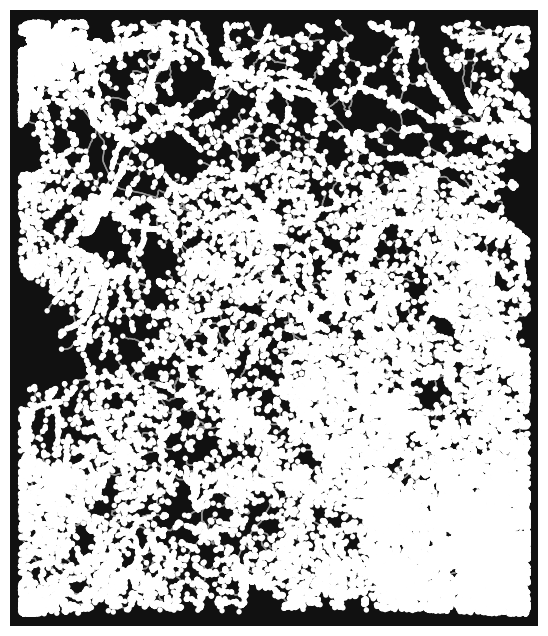

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [44]:
gdf_nodes, gdf_relationships = ox.graph_to_gdfs(full_graph)
north, south, east, west = gdf_nodes[['y']].max(), gdf_nodes[['y']].min(), gdf_nodes[['x']].min(), gdf_nodes[['x']].max()
GG = ox.graph_from_bbox(bbox = (north, south, east, west), network_type='drive')
ox.plot_graph(GG)

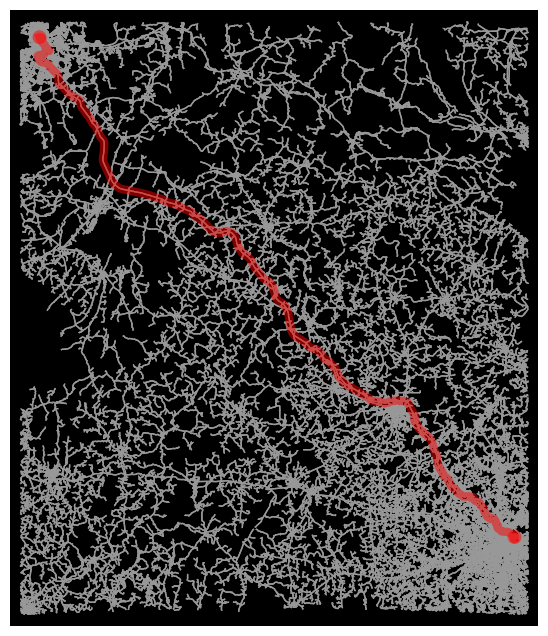

In [46]:
route = nx.shortest_path(GG, 1707254890, 10736808203)
fig, ax = ox.plot_graph_route(GG, route, route_linewidth=6, node_size=0, bgcolor='k')

In [54]:
def generate_multindex(route_nodes):
    multiindex_list = []
    # append the index to list
    for u, v in zip(route_nodes[:-1], route_nodes[1:]):
        multiindex_list.append((u, v, 0))
    return multiindex_list


# get edges from from above multidigraph
gdf_nodes, gdf_edges = ox.graph_to_gdfs(GG)

# generate multiindex based on generated shortest route
multiindex_list = generate_multindex(route)
# fetch edge details based on multi index list
shrt_gdf_edges = gdf_edges[gdf_edges.index.isin(multiindex_list)]
# plot the shortest route on map
shrt_gdf_edges.explore(color="red")

___

In [61]:
city_from = 'Tallinn'
city_to = 'Helsinki'

full_df_from = pd.concat([func_tags(tags_port, city_from), func_tags(tags_aeroway, city_from), func_tags(tags_landuse, city_from), func_tags(tags_build, city_from)], ignore_index=True)
full_df_to = pd.concat([func_tags(tags_port, city_to), func_tags(tags_aeroway, city_to), func_tags(tags_landuse, city_to), func_tags(tags_build, city_to)], ignore_index=True)

G_from = ox.graph_from_place(city_from, retain_all=True, simplify = True, network_type='drive')
G_to = ox.graph_from_place(city_to, retain_all=True, simplify = True, network_type='drive')

lat_from = list(full_df_from['lat'].values)
lon_from = list(full_df_from['lon'].values)

lat_to = list(full_df_to['lat'].values)
lon_to = list(full_df_to['lon'].values)

full_graph = nx.compose_all([G_from, G_to])
full_df_from['new_nodes'] = ox.distance.nearest_nodes(full_graph, lon_from, lat_from)
full_df_to['new_nodes'] = ox.distance.nearest_nodes(full_graph, lon_to, lat_to)

In [72]:
full_df_from.sample(2)

,name,lat,lon,geometry,nodes,kind_of,new_nodes
1,Vanasadam,59.444022,24.774418,"MULTIPOLYGON (((24.75972 59.44545, 24.76040 59...","[[[9055928766, 294510701, 11741309866, 5884596...",industrial,6726297219
2,Tallinna lennujaam,59.414383,24.836851,"POLYGON ((24.87762 59.41361, 24.87396 59.41454...","[521306701, 521306702, 4264883505, 4264883510,...",aeroway,989935973


In [66]:
full_df_to.sample(2)

,name,lat,lon,geometry,nodes,kind_of,new_nodes
5,Merikasarmin laituri,60.169307,24.973081,"POLYGON ((24.97561 60.16989, 24.97546 60.17003...","[5473237210, 5473237211, 9859299793, 198285660...",industrial,30558077
17,Varasto-osake.fi,60.237405,24.860754,"POLYGON ((24.86098 60.23737, 24.86105 60.23737...","[6344798806, 6344798800, 6344798801, 634479880...",building,1044882335


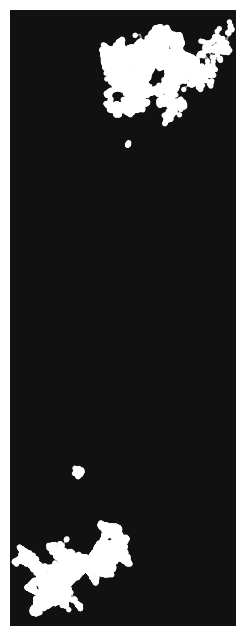

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [73]:
ox.plot_graph(full_graph)

C:\Users\orenc\AppData\Local\Temp\ipykernel_4444\2176248734.py:3: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  GGG = ox.graph_from_bbox(bbox = (north, south, east, west), network_type='drive', retain_all=True)
c:\mArt\dataScience\Practice_3sem\project's\1\.venv\lib\site-packages\shapely\geometry\polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


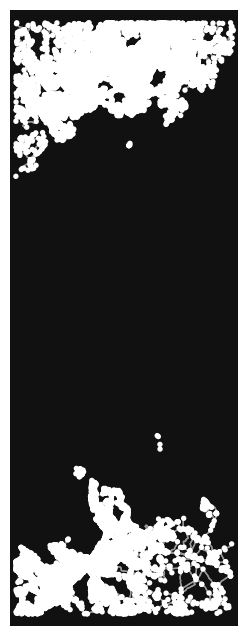

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [76]:
gdf_nodes, gdf_relationships = ox.graph_to_gdfs(full_graph)
north, south, east, west = gdf_nodes[['y']].max(), gdf_nodes[['y']].min(), gdf_nodes[['x']].min(), gdf_nodes[['x']].max()
GGG = ox.graph_from_bbox(bbox = (north, south, east, west), network_type='drive', retain_all=True)
ox.plot_graph(GGG)

In [77]:
route = nx.shortest_path(GGG, 6726297219, 30558077)
fig, ax = ox.plot_graph_route(GGG, route, route_linewidth=6, node_size=0, bgcolor='k')

NetworkXNoPath: No path between 6726297219 and 30558077.